# LoFTR Test

In [1]:
import os
import cv2
import kornia as K
import kornia.feature as KF
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import torch
from kornia_moons.viz import draw_LAF_matches
import skimage as ski

In [2]:
from loftr import load_resize_image, loftr_match, plot_matches, plot_matches_conf, plot_match_coverage, tps_skimage, plot_img_transform, plot_overlay

In [3]:
img_folder = "../leaf-image-sequences/processed/reg/ESWW0070020_1/crop/"
img1_path = img_folder + "20230525_172420_ESWW0070020_1.JPG"
img2_path = img_folder + "20230527_102010_ESWW0070020_1.JPG"
img_last_path = img_folder + "20230608_162957_ESWW0070020_1.JPG"

assert os.path.exists(img1_path) and os.path.exists(img2_path) and os.path.exists(img_last_path), "Invalid path to images"

img1 = load_resize_image(img1_path)
img2 = load_resize_image(img2_path)
img_last = load_resize_image(img_last_path)

print(f"Img size: {(img1.nelement() * img1.element_size())/1000000} MB")

Img size: 2.7 MB


## Match first and second image

In [4]:
# match with LoFTR
mkpts1, mkpts2, confidence, inliers = loftr_match(img1, img2)

Total matches: 1206
Matches with Confidence > 0.5: 797
Inliers: 570 (47.26%)


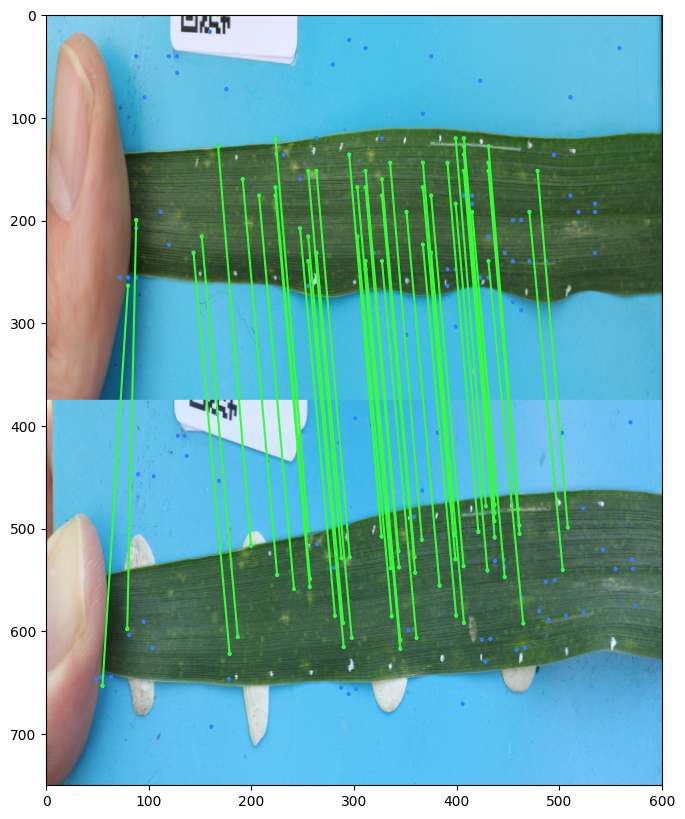

In [5]:
# plot matches
fig, ax = plot_matches(img1, mkpts1, img2, mkpts2, inliers, inliers_only=False)
fig.show()

## Plot Confidence

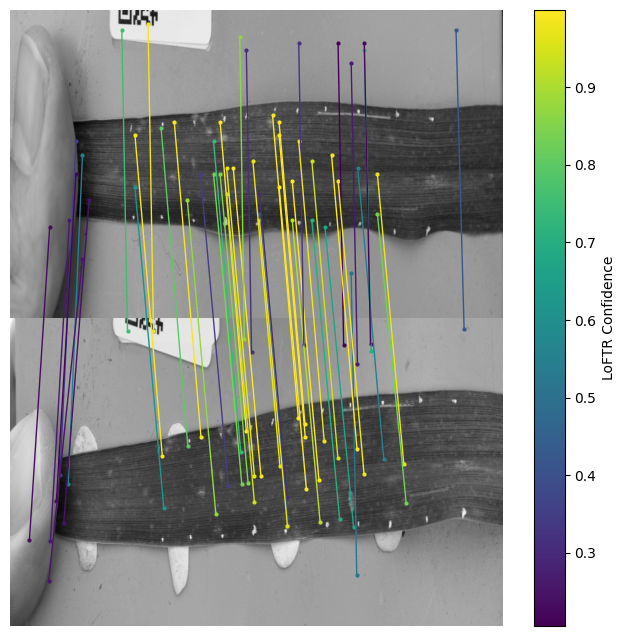

In [6]:
fig, ax = plot_matches_conf(img1, mkpts1, img2, mkpts2, confidence, N_show=50, vertical=True)
fig.show()

## Plot Spatial Coverage

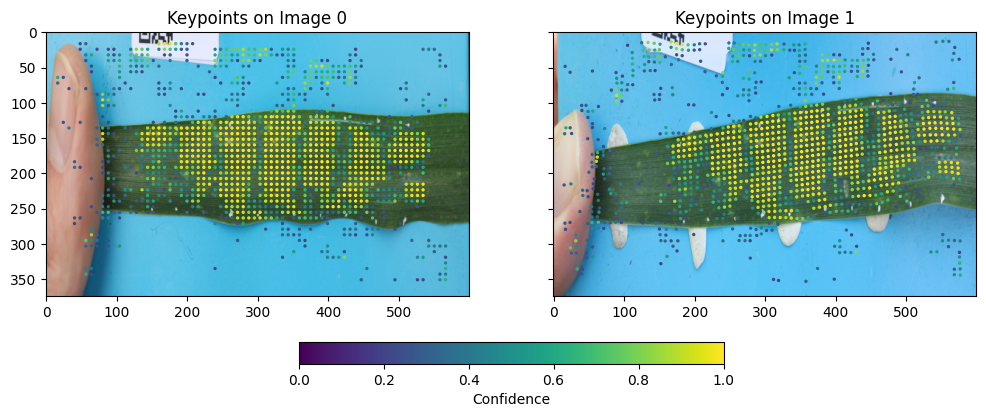

In [7]:
fig, axs = plot_match_coverage(img1, mkpts1, img2, mkpts2, confidence)
fig.show()

## Thin Plate Spline

In [8]:
thrsld = 0.75
print(f"Remaining Keypoints: {mkpts1[confidence > thrsld].shape[0]}")

Remaining Keypoints: 578


In [9]:
img1_mks = mkpts1[confidence > thrsld]
img2_mks = mkpts2[confidence > thrsld]
warped, tps = tps_skimage(mkpts1, mkpts2, confidence, thrsld, img2)

In [10]:
tps_inv = ski.transform.ThinPlateSplineTransform()
tps_inv.estimate(img2_mks, img1_mks) # estimate transform from img2 → img1
warped_keypts = tps_inv(img2_mks)

In [11]:
warped_keypts.shape

(578, 2)

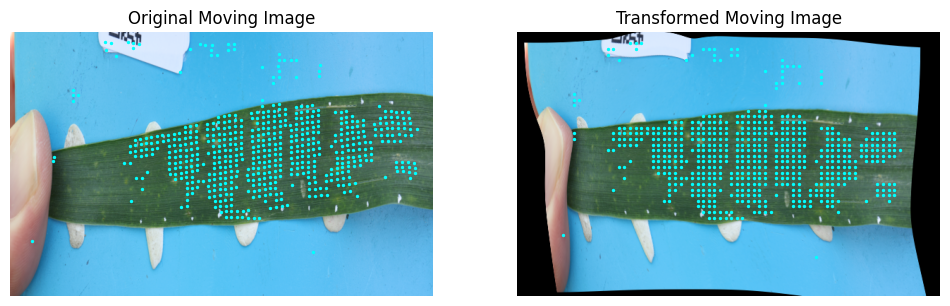

In [12]:
# plot original + warped moving image
fig, axs = plot_img_transform(img2, warped, plot_keypts=True, keypts_mov=img2_mks, keypts_warped=warped_keypts)
fig.show()

### Overlay

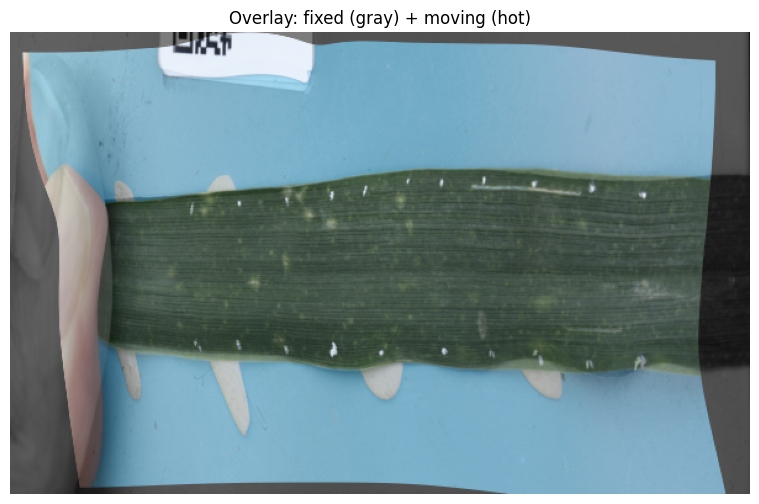

In [13]:
fig = plot_overlay(img1, warped)
fig.show()

### Keypoint Alignment

In [14]:
# Image 1 keypoints vs warped keypoints of image 2:
mae_12 = np.mean(img1_mks.numpy() - warped_keypts)
print(f"Alignment Error of Keypoints of Image 1 vs Warped Keypoints of Image 2:    {mae_12:.5} (MAE)")

# Image 2 keypoints vs warped keypoints of image 1:
warped_keypts_img1 = tps(img1_mks)
mae_21 = np.mean(img2_mks.numpy() - warped_keypts_img1)
print(f"Alignment Error of Keypoints of Image 2 vs Warped Keypoints of Image 1:    {mae_21:.5} (MAE)")

Alignment Error of Keypoints of Image 1 vs Warped Keypoints of Image 2:    3.5654e-05 (MAE)
Alignment Error of Keypoints of Image 2 vs Warped Keypoints of Image 1:    3.5987e-06 (MAE)


## First vs Last Image

In [15]:
# match with LoFTR
mkpts_0, mkpts_l, confidence_l, inliers_l = loftr_match(img1, img_last)

Total matches: 248
Matches with Confidence > 0.5: 63
Inliers: 54 (21.77%)


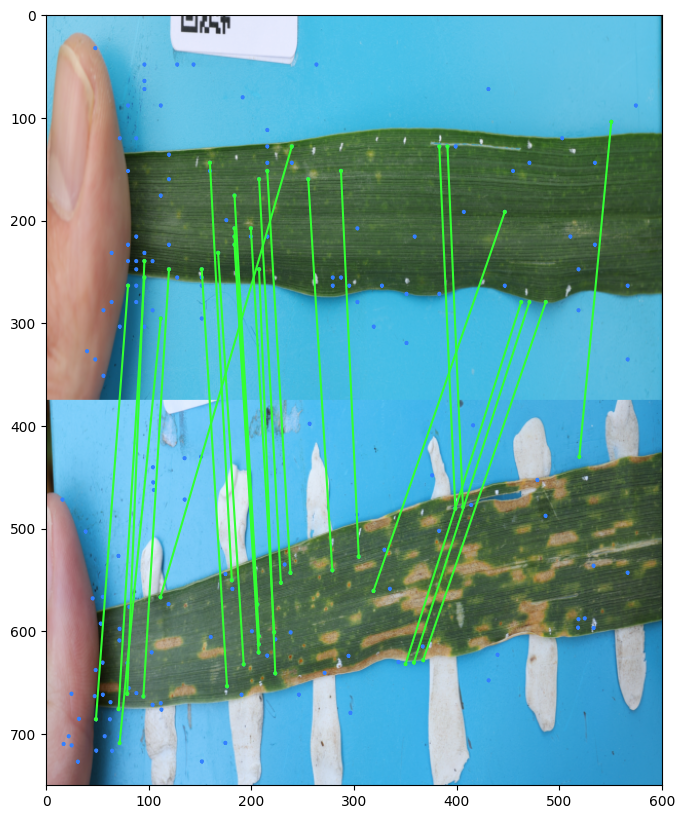

In [16]:
# plot matches
fig, ax = plot_matches(img1, mkpts_0, img_last, mkpts_l, inliers_l, inliers_only=False)
fig.show()

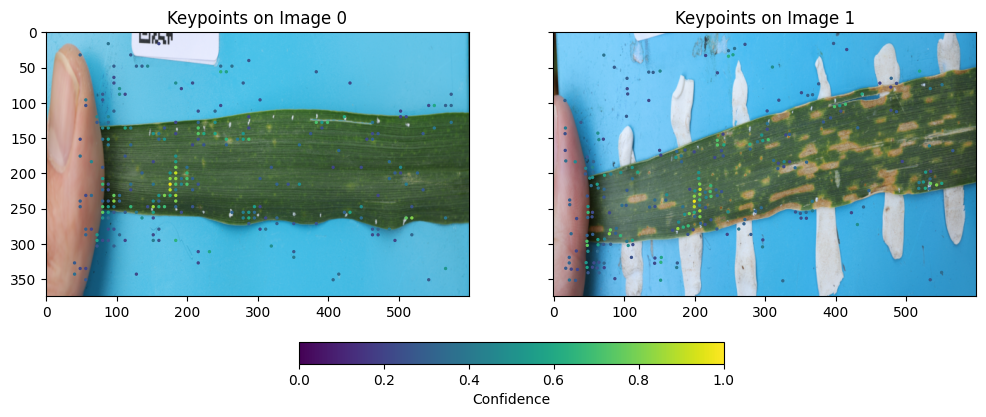

In [17]:
# plot covergae
fig, axs = plot_match_coverage(img1, mkpts_0, img_last, mkpts_l, confidence_l)
fig.show()

### TPS

In [18]:
img_0_mks = mkpts_0[confidence_l > thr
img_l_mks = mkpts_l[confidence_l > thrsld]
warped_l, tps_l = tps_skimage(mkpts_0, mkpts_l, confidence_l, thrsld, img_last)

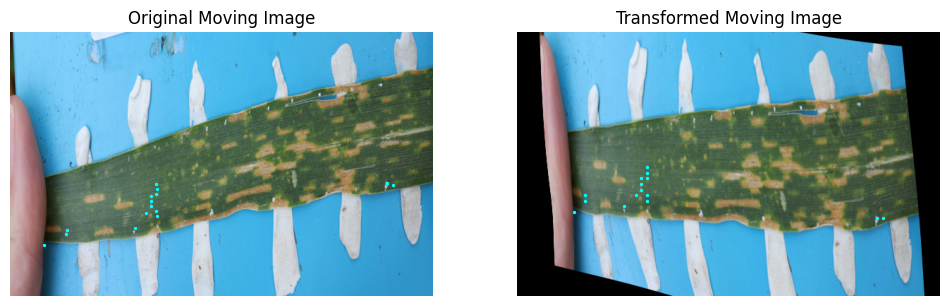

In [19]:
# plot original + warped moving image
fig, axs = plot_img_transform(img_last, warped_l, plot_keypts=True, keypts_mov=img_l_mks, keypts_warped=img_0_mks)
fig.show()

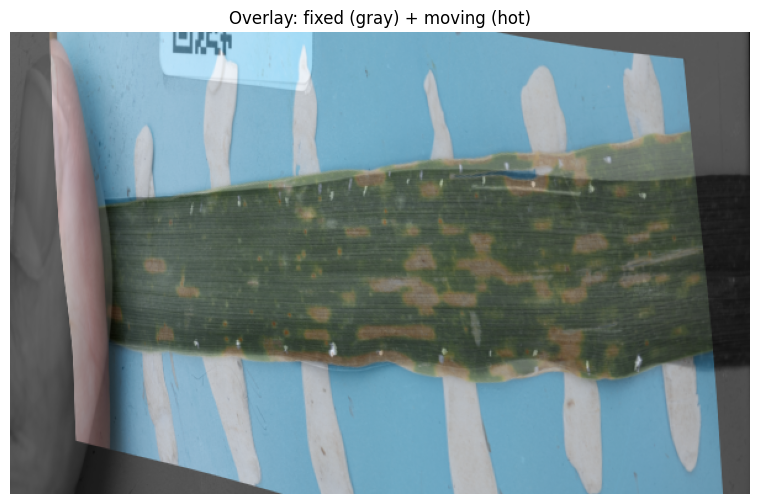

In [20]:
fig = plot_overlay(img1, warped_l)
fig.show()

In [21]:
# Image 2 keypoints vs warped keypoints of image 1:
warped_keypts_img1 = tps_l(img_0_mks)
mae_l1 = np.mean(img_l_mks.numpy() - warped_keypts_img1)
print(f"Alignment Error of Keypoints of Last Image vs Warped Keypoint of Image 1:    {mae_l1:.5} (MAE)")

Alignment Error of Keypoints of Last Image vs Warped Keypoint of Image 1:    2.448e-05 (MAE)
